## Model
<figure><img src="../../../images/hill model.png\" width=400 />


## Deduction

   $ F_{SEE} = \left\{\begin{array}{l}
   0\ \ , \ \ L_T < L_{SL}\\
   K(L - L_{SL})^2 \ \ , \ \ L_T \geq L_{SL}\\
   \end{array}
   \right.$
   
   $F_{KPE} = \left\{\begin{array}{l}
   0\ \ , \ \ L_{CE} < L_{op}\\
   K(L - L_{op})^2 \ \ , \ \ L_{CE} \geq L_{op}\\
   \end{array}
   \right.$
     
  
   $F = \frac{F_{SEE}}{cos(\alpha)} - F_{KPE} = F_{CE} $
     
   $\dot L_{CE} = (0.25 + 0.75a)V_{max}\frac{F_{CE}-aF_L}{b} $
   
   $ b = \left\{\begin{array}{l}
   aF_L + F_{CE}/A_f\ \ , \ \ F_{CE} < F_L\\
   \frac{(2 + 2/A_f)(aF_L\overline{F}^M_{len} - F_{CE})}{\overline{F}^M_{len} - 1}   \ \ , \ \ F_{CE} \geq F_L\\
   \end{array}
   \right.$
   
   $\frac{da}{dt} = \frac{u - a}{\tau_a(u,a)}$
   
   $\tau_a(a,u) = \left\{\begin{array}{l}
   \tau_{act}(0.5 + 1.5a)\ \ , \ \ u > a\\
   \frac{\tau_{dact}}{(0.5 + 1.5a)}\ \ , \ \ u \leq a\\
   \end{array}
   \right.$
   
   $L_{SEE} = L_m - L_{CE} cos(\alpha)$

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib notebook
from Muscle import Muscle

In [2]:
#Muscle properties -Parameters obtained from Table 2 of Thelen (2003).

####### Dorsiflexor

Lce_o_DOR = 0.09 #optimal length of CE (meter)(telen 2003 dorsiflexor)
Lslack_DOR = 2.4*Lce_o_DOR #slack length of SEE, SEE strain at Fmax (meters)(telen 2003 dorsiflexor)
Fmax_DOR = 1400 #maximal isometric force (Newton)(telen 2003 dorsiflexor)
alpha_DOR = 7*np.pi/180 #penation angle degree

####### Soleus

Lce_o_SOL = 0.049 #optimal length of CE (meter)(telen 2003 dorsiflexor)
Lslack_SOL = 0.289 #slack length of SEE, SEE strain at Fmax (meters)(telen 2003 dorsiflexor)
Fmax_SOL = 8050 #maximal isometric force (Newton)(telen 2003 dorsiflexor)
alpha_SOL = 25*np.pi/180 #penation angle (Input the valeu in degrees)

############################################################################################################################

#Activation Parameter
tau_dact = 50e-3 #young #ms
#tal_dact = 0.060 #old #ms
tau_act = 15e-3 #ms


############################################################################################################################

#Contract Elemente
Af = 0.25
F_m_len = 1.4 #young
#F_m_len = 1.8 #old
v_max = 10 #young
#v_max = 8 #old

############################################################################################################################

dt = 0.01

In [3]:
As_TA  = np.array([30.6, -7.44e-2, -1.41e-4,  2.42e-6,  1.50e-8])/100
Bs_TA  = np.array([ 4.3,  1.66e-2, -3.89e-4, -4.45e-6, -4.34e-8])/100
As_SOL = np.array([32.3,  7.22e-2, -2.24e-4, -3.15e-6,  9.27e-9])/100
Bs_SOL = np.array([-4.1,  2.57e-2,  5.45e-4, -2.22e-6, -5.50e-9])/100

## Parameters

## Functions

In [4]:
def computeMomentArm(phi,Bs):
    """
    Inputs:
        phi - joint's flexion degree 
    Output:
        Rf - joint's moment arm of 
    """
    theta_degree = phi*180/np.pi
    Rf = 0
    
    for i in range(len(Bs)):
        Rf = Rf + (Bs[i]*theta_degree**i)
        
    return Rf

In [5]:
def computeTotalLenghtSize(phi,As):
    """
    Inputs:
        Phi = joint's flexion degree 
    Output:
        Lm = total muscle lenght
    """

    theta_degree = phi*180/np.pi
    Lm = 0
    
    for i in range(len(As)):
        Lm = Lm + (As[i]*theta_degree**i)
        
    
    return Lm

In [6]:
def computeMomentKnee(Rf_TA,F0norm_TA,m,hcm,phi,Fmax_TA,theta_leg,Rf_SOL, F0norm_SOL, Fmax_SOL):
    """"
    Inputs:
        RF = Moment arm
        F = Normalized tendon force
        m = Segment Mass
        g = Acelleration of gravity
        Fmax= maximal isometric force
    Output:
        M = Total moment with respect to joint
    """
    
    g = 9.81
    
    M = (-0.65*m*g*hcm*phi) + Rf_TA*F0norm_TA*Fmax_TA + Rf_SOL*F0norm_SOL*Fmax_SOL + m*g*hcm*np.sin(phi)
    
    return M

In [7]:
def computeFlexionAngleVelocity(M,I):
    """
    Inputs:
        M = Total moment with respect to joint
        I = Moment of Inertia
    Output:
        phidd= angular aceleration of the joint
    """

    phidd = M/I #angular acceleration
    
    return phidd

In [8]:
dorsiflexor = Muscle(Lslack = Lslack_DOR, Lce_o = Lce_o_DOR, Fmax = Fmax_DOR, alpha = alpha_DOR, dt = dt)
soleus      = Muscle(Lslack = Lslack_SOL, Lce_o = Lce_o_SOL, Fmax = Fmax_SOL, alpha = alpha_SOL, dt = dt)

In [9]:
## Muscle properties for human Vastus Lateralis

##parameters for the equation of motion (Nigg & Herzog, p. 562)
Mc = 75 #total mass in kg
proportion_mass = 1
m = Mc*proportion_mass #kg
Lseg = 0.26 #meters
CM = 0.5 #Center of Mass
hcm = 0.85 #distance knee joint to centre of mass(meter)
Rg_norm = 0.69
I = 4/3*m*hcm**2  #moment of inertia
theta_leg = np.pi/2

##Initial condition
phi = 5*np.pi/180
phid = 0 #start as 90 degree flexion and zero velocity

dorsiflexor.Lnorm_ce = 1
soleus.Lnorm_ce      = 1

tf = 60.0

t = np.arange(0,tf,dt)
a_vector =  np.empty_like(t)
F_kpe_norm = np.empty_like(t)
F_CE_norm = np.empty_like(t)
F_tot = np.empty_like(t)
F_tot2 = np.empty_like(t)
fiber_length_d = np.empty_like(t)
fiber_length_s = np.empty_like(t)
tendon_length = np.empty_like(t)
angle_phi = np.empty_like(t)
velocity_phi = np.empty_like(t)
fibervelocity = np.empty_like(t)
Rf_v = np.empty_like(t)
Lm_v = np.empty_like(t)
moment = np.empty_like(t)
a_sol = np.empty_like(t)
Lce_dot_d = np.empty_like(t)
Lce_dot_s = np.empty_like(t)

kp_TA=1500
kd_TA=15
kp_SOL=70
kd_SOL=7

#kp_TA=920
#kd_TA=10
#kp_SOL=75
#kd_SOL=10

Lce_ref_TA = 0.086
Lce_ref_SOL = 0.037

## Muscle Model

In [10]:
noise=0.1*np.random.randn(len(t))*1/dt*0
phiRef = 5*np.pi/180

filtNoise = noise



for i in range(len(t)):
        
    #################################################################################################################
    
    Rf_TA = computeMomentArm(phi,Bs_TA)
    Lm_TA = computeTotalLenghtSize(phi,As_TA)
    Rf_SOL = computeMomentArm(phi,Bs_SOL)
    Lm_SOL = computeTotalLenghtSize(phi,As_SOL)
       
    #################################################################################################################
    #Control
    
    e_TA  = Lce_ref_TA  - dorsiflexor.Lnorm_ce*dorsiflexor.Lce_o
    e_SOL = Lce_ref_SOL - soleus.Lnorm_ce*soleus.Lce_o
    
    if e_TA >0:
        u_TA  = 0.01        
    else:
        u_TA  = max(min(1,(-kp_TA*e_TA +kd_TA*dorsiflexor.Lnorm_cedot*dorsiflexor.Lce_o)),0.01)
        
    if e_SOL >0:
        u_SOL  = 0.01        
    else:
        u_SOL  = max(min(1,(-kp_SOL*e_SOL +kd_SOL*soleus.Lnorm_cedot*soleus.Lce_o)),0.01)
    #################################################################################################################
    
    dorsiflexor.updateMuscle(Lm = Lm_TA, u = u_TA)
    soleus.updateMuscle(Lm = Lm_SOL, u = u_SOL)
    
    #################################################################################################################
        
    M =  computeMomentKnee(Rf_TA, dorsiflexor.Fnorm_tendon, m, hcm, phi, dorsiflexor.Fmax, theta_leg, Rf_SOL, 
                           soleus.Fnorm_tendon, soleus.Fmax) # total moment with respect to knee joint
    
    torqueNoise = M + filtNoise[i]
    
    phidd = computeFlexionAngleVelocity(torqueNoise,I)
    
    phid = phid+ dt*phidd
    
    phi = phi + phid*dt
    
    #################################################################################################################
    
    F_tot[i] = dorsiflexor.Fnorm_tendon* dorsiflexor.Fmax
    F_tot2[i] = soleus.Fnorm_tendon*soleus.Fmax
    tendon_length[i] = dorsiflexor.Lnorm_see* dorsiflexor.Lce_o
    
    velocity_phi[i] = phid
    angle_phi[i] = phi
    fibervelocity[i] = dorsiflexor.Lnorm_cedot* dorsiflexor.Lce_o
    Rf_v[i] = Rf_TA
    Lm_v[i] = Lm_TA
    moment[i] = M
    
    fiber_length_d[i] =  dorsiflexor.Lnorm_ce* dorsiflexor.Lce_o
    fiber_length_s[i] = soleus.Lnorm_ce*soleus.Lce_o
        
    a_vector[i] =  dorsiflexor.a
    a_sol[i] = soleus.a
    
    Lce_dot_d[i] = dorsiflexor.Lnorm_cedot*dorsiflexor.Lce_o
    Lce_dot_s[i] = soleus.Lnorm_cedot*soleus.Lce_o
    

## Angle

<IPython.core.display.Javascript object>


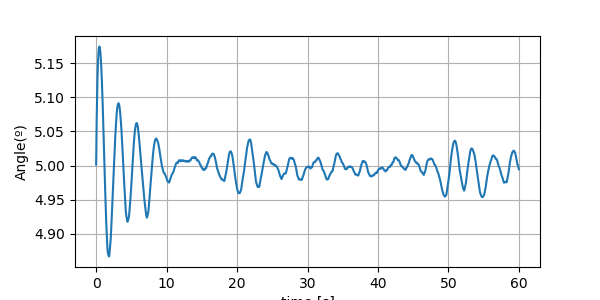

In [16]:
plt.figure(figsize=(6,3))
plt.grid()
plt.plot(t, angle_phi*180/np.pi)
plt.xlabel ('time [s]')
plt.ylabel ('Angle(º)')
plt.show()

## Activation

<IPython.core.display.Javascript object>


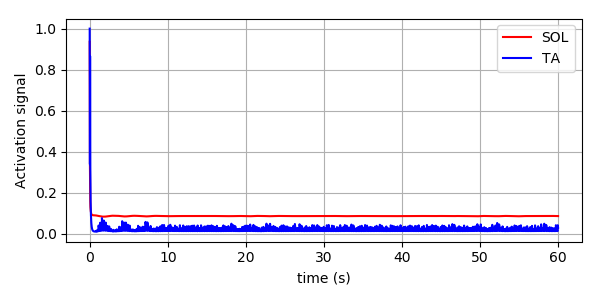

In [17]:
plt.figure(figsize=(6,3))
plt.grid()

plt.plot(t, a_sol, c = 'r',label = 'SOL')
plt.plot(t, a_vector, c = 'b',label = 'TA')
plt.xlabel('time (s)')
plt.ylabel('Activation signal')
plt.legend(loc='best')
plt.tight_layout()

## Tendon Force

<IPython.core.display.Javascript object>


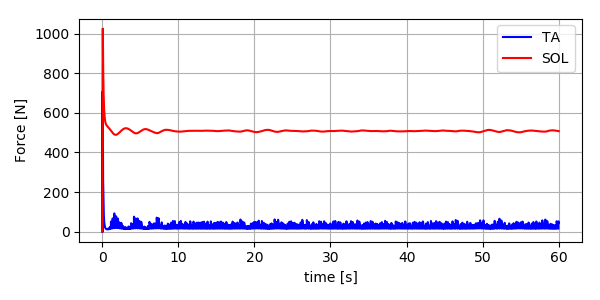

In [18]:
plt.figure(figsize=(6,3))
plt.plot(t,F_tot, c = 'blue',label = 'TA')
plt.plot(t,F_tot2, c = 'red',label = 'SOL')
plt.grid()
plt.xlabel ('time [s]')
plt.ylabel ('Force [N]')
plt.legend(loc='best')
plt.tight_layout()

## Joint Moment

<IPython.core.display.Javascript object>


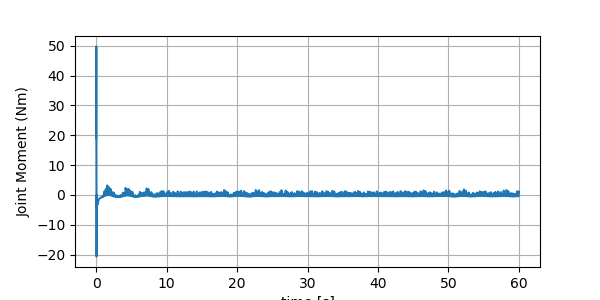

Text(0,0.5,'Joint Moment (Nm)')

In [20]:
plt.figure(figsize=(6,3))
plt.plot(t,moment,)
plt.grid()
plt.xlabel ('time [s]')
plt.ylabel ('Joint Moment (Nm)')